# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

disable deprecated pandas warning

In [2]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

Default variable

In [3]:
DEFAULT_EXPLANATION_PERIOD = 720
DEFAULT_IN_SAMPLE_MONTH = 1
DEFAULT_HALF_LIFE = 3600

# Data pipeline

## Base data import

We create function to import the bin and fill data (by sampling many CSV files)

In [4]:
def import_data(path="data_lobster/binSamples",file_limit = None,columns = ["date","time","stock","trade","mid"]):
    columns = columns + ["date"] if "date" not in columns else columns
    data = pd.DataFrame(columns=columns)
    file_limit = len(os.listdir(path=path)) if file_limit is None else min(len(os.listdir(path=path)),file_limit)
    for index,csv_file in enumerate(os.listdir(path=path)[:file_limit]):
        print(f"Reading file : {index+1} out of {file_limit} ...",end="\r")
        df = pd.read_csv(f"{path}/{csv_file}")[columns]
        data = pd.concat([data,df])
    data["date"] = pd.to_datetime(data["date"])
    data = data.drop_duplicates()
    print(f"Done reading file.                      ",end="\r")
    return data

In [5]:
if "bin_sample_all_file.csv" not in os.listdir("data_lobster/refined_data/") : 
    bin_sample_df = import_data(path="data_lobster/binSamples",file_limit = 6)
    bin_sample_df.to_csv("data_lobster/refined_data/bin_sample_all_file.csv",index=False)
else:
    bin_sample_df = pd.read_csv("data_lobster/refined_data/bin_sample_all_file.csv")
    bin_sample_df["date"] = pd.to_datetime(bin_sample_df["date"])

In [6]:
if "fill_sample_all_file.csv" not in os.listdir("data_lobster/refined_data/") : 
    fill_sample_df = import_data(path="data_lobster/fillSamples",file_limit = 6)
    fill_sample_df.to_csv("data_lobster/refined_data/fill_sample_all_file.csv",index=False)
else:
    fill_sample_df = pd.read_csv("data_lobster/refined_data/fill_sample_all_file.csv")
    fill_sample_df["date"] = pd.to_datetime(fill_sample_df["date"])

## Volume curves

In [7]:
def pivot_trade_px_df(trade_df : pd.DataFrame)->pd.DataFrame:
    return trade_df[["stock", "date", "mid", "time"]].pivot(index=["stock", "date"], columns=["time"])["mid"].fillna(method="ffill", axis="columns").fillna(method="bfill", axis="columns")

In [8]:
def pivot_trade_volume_df(trade_df:pd.DataFrame)->pd.DataFrame:
    return trade_df[["stock", "date", "trade","time"]].pivot(index=["stock", "date"],columns=["time"])["trade"].fillna(0).astype(int)

In [9]:
def get_volume_curve_df(bin_sample_data:pd.DataFrame,date = None)->pd.DataFrame :
    if date is not None:
        #If date is not None => Need to truncate the input dataframe to the last month before the provided date
        #Else, assume it's already been done
        bin_sample_data = bin_sample_data[(date - bin_sample_data["date"]<=datetime.timedelta(days = 31)) & (date - bin_sample_data["date"] >= datetime.timedelta(days=0))]
    traded_volume_df = pivot_trade_volume_df(bin_sample_data)
    unsigned_traded_volume_df = traded_volume_df.abs().reset_index()
    volume_curve_df = unsigned_traded_volume_df.groupby(["stock"]).mean()
    volume_curve_df.iloc[:,:] = volume_curve_df.values[:,::-1].cumsum(axis=1)[:,::-1] 
    return volume_curve_df

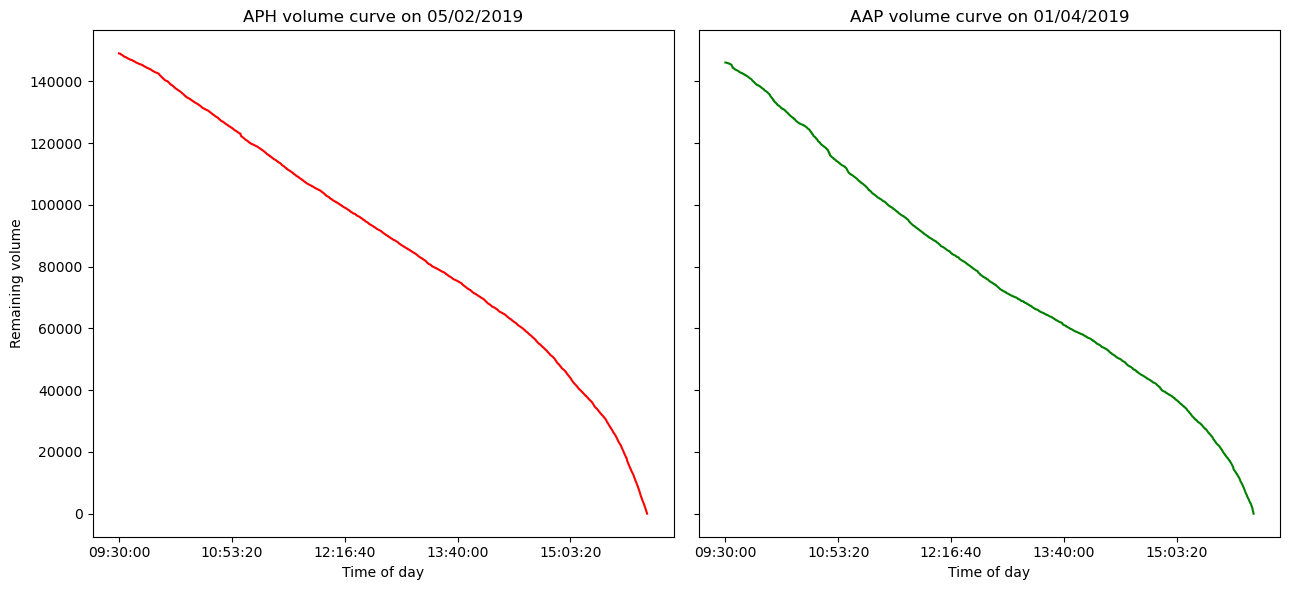

In [10]:
stock_date_pairs = [("APH",datetime.datetime(year = 2019,day = 5, month = 2),"red"),("AAP",datetime.datetime(year = 2019,day = 1, month = 4),"green")]

fig,axs = plt.subplots(1,2,figsize = (13,6),sharey=True)
for index,(stock,date,color) in enumerate(stock_date_pairs):
    ax = axs[index]
    monthly_volume_curve_df = get_volume_curve_df(bin_sample_data=bin_sample_df,date = date)
    monthly_volume_curve_df.loc[stock,:].T.plot(ax = ax,color=color)
    ax.set_title(f"{stock} volume curve on {date.strftime(format='%d/%m/%Y')}")
    if index <len(stock_date_pairs)-1:
        ax.set_ylabel("Remaining volume")
    ax.set_xlabel("Time of day")
plt.tight_layout()
plt.show()

We compute the volume curve for all the stocks for the entire year-worth of data

In [11]:
volume_curve_df = get_volume_curve_df(bin_sample_df,date=None)
# volume_curve_df.to_csv("data_lobster/refined_data/volume_curve_df_all_year.csv",index=False)

# Pratical example : VWAP schedules

In [12]:
def VWAP_naive(v : np.ndarray,Q : float,V : np.ndarray = None) -> np.ndarray:
    """
    v : volume traded at each time interval t (starts from 9:00 to 16:00 with one datapoint every 10sec)
    Q : target volume trade

    qt (naive) = abs(vt) / sigma_s(abs(vs)) * Q
    """
    sigma_v = np.abs(v).sum()
    q = np.abs(v)/sigma_v * Q
    return q

def VWAP_slippage(v : np.ndarray,Q : float,V : np.ndarray = None) -> np.ndarray:
    """
    v : volume traded at each time interval t (starts from 9:00 to 16:00 with one datapoint every 10sec)
    Q : target volume trade

    qt (slippage) = abs( v(t-dt) ) / sigma_s(abs(vs)) * Q
    """
    rolled_v =  np.roll(v, 1)
    rolled_v[0] = 0
    sigma_v = np.abs(rolled_v).sum()
    q = np.abs(rolled_v)/sigma_v * Q
    return q


def VWAP_realistic(v : np.ndarray,Q : float,V : np.ndarray = None) -> np.ndarray:
    """
    v : volume traded at each time interval t (starts from 9:00 to 16:00 with one datapoint every 10sec)
    V : average traded volume at each time interval t
    Q : target volume trade
    """
    n = len(v)
    q_realistic = np.zeros_like(v)

    abs_v_rolled = np.abs(np.roll(v, 1))
    abs_v_rolled[0] = 0

    q_realistic[0] = np.minimum(abs_v_rolled[0] / V[0] * Q, Q)

    for t in range(1, n):
        q_cumulative = q_realistic[:t].sum()
        q_remaining = np.maximum(Q - q_cumulative, 0)
        q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)

    return q_realistic

C:\Users\Dedie\AppData\Local\Temp\ipykernel_6396\2468918063.py:43: RuntimeWarning: divide by zero encountered in true_divide
  q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)
C:\Users\Dedie\AppData\Local\Temp\ipykernel_6396\2468918063.py:43: RuntimeWarning: divide by zero encountered in true_divide
  q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)
C:\Users\Dedie\AppData\Local\Temp\ipykernel_6396\2468918063.py:43: RuntimeWarning: divide by zero encountered in true_divide
  q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)
C:\Users\Dedie\AppData\Local\Temp\ipykernel_6396\2468918063.py:43: RuntimeWarning: divide by zero encountered in true_divide
  q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)


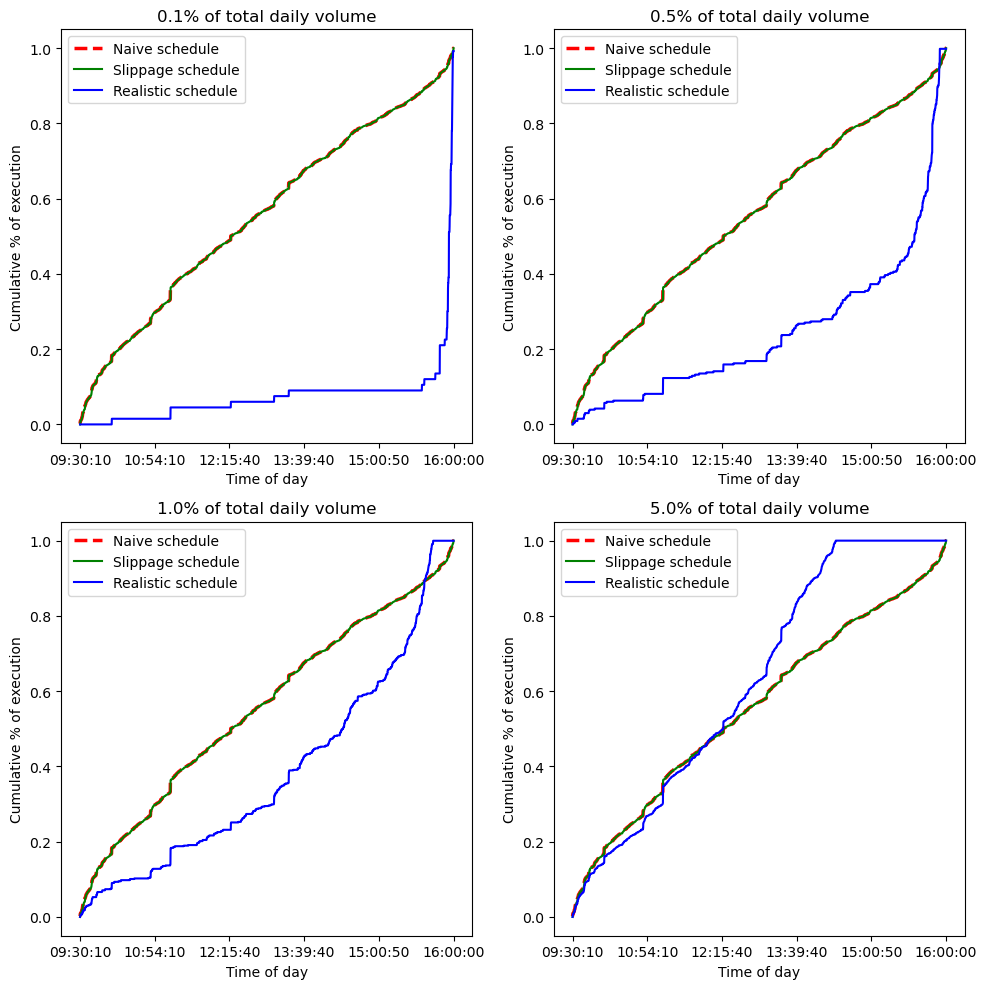

In [13]:
date = datetime.datetime(day = 5,month = 2,year = 2019)
stock = "AAPL"

v = pivot_trade_volume_df(bin_sample_df)
V = get_volume_curve_df(bin_sample_data=bin_sample_df,date=date)


v = v.loc[stock].loc[date].values
V = V.loc[stock].values
Q_pcts = [0.001,0.005,0.01,0.05]

fig,axs = plt.subplots(2,2,figsize = (10,10))
x_values = bin_sample_df["time"].unique()
for index,Q_pct in enumerate(Q_pcts):
    q1 = VWAP_naive(v=v,V = V,Q = Q_pct * v.sum()).cumsum() / (Q_pct * v.sum())
    q2 = VWAP_slippage(v=v,V = V,Q = Q_pct * v.sum()).cumsum() / (Q_pct * v.sum())
    q3 = VWAP_realistic(v=v,V = V,Q = Q_pct * v.sum()).cumsum() / (Q_pct * v.sum())

    ax = axs[index//2][index%2]

    ax.plot(x_values,q1,color="red",label="Naive schedule" ,linestyle = "dashed",linewidth=2.5)
    ax.plot(x_values,q2,color="green",label="Slippage schedule")
    ax.plot(x_values,q3,color="blue",label="Realistic schedule")

    step = len(ax.get_xticks()) // 5
    ax.set_xticks(ax.get_xticks()[::step])

    ax.set_title(f"{Q_pct * 100:.1f}% of total daily volume")
    ax.legend()

    ax.set_xlabel("Time of day")
    ax.set_ylabel("Cumulative % of execution")
plt.tight_layout()
# fig.suptitle(f"Different VWAP schedule for different percentage of total volume of {stock} on {date.strftime('%d/%m/%Y')}", fontsize=16)
plt.show()

# Price impact models

### Computing average daily volume and volatility

In [14]:
def compute_average_daily_volume_and_vol(bin_sample_data:pd.DataFrame) -> pd.DataFrame : 
    adv_ret = bin_sample_data[["stock", "date", "mid","time"]].pivot(index=["stock", "date"],columns=["time"])["mid"]
    adv_ret = adv_ret.fillna(method="bfill",axis=1).fillna(method="ffill",axis=1)
    adv_ret.iloc[:,:] = (adv_ret.iloc[:,:]-np.roll(adv_ret.iloc[:,:],1,axis=1)) / adv_ret.iloc[:,:]
    adv_ret.iloc[:,0] = 0.
    adv_ret["px_vol"] = adv_ret.std(axis=1)
    adv_ret = adv_ret["px_vol"]
    adv_vol = bin_sample_df[["stock", "date","trade"]]
    adv_vol = adv_vol.assign(trade= adv_vol["trade"].abs() )
    adv_vol = adv_vol.groupby(["stock","date"]).agg({"trade":"sum"}).rename(columns= {"trade":"volume"})
    adv_vol = adv_vol.assign(px_vol=adv_ret)
    return adv_vol

def compute_average_rolling_volume_and_vol(adv:pd.DataFrame,window_days = 20) ->pd.DataFrame:
    adv_vol_rolling_mean = adv.rolling(window=window_days).mean().shift(1).dropna()
    return adv_vol_rolling_mean

In [15]:
adv_vol = compute_average_daily_volume_and_vol(bin_sample_df)
adv_vol_rolling_mean = compute_average_rolling_volume_and_vol(adv_vol)

In [16]:
class PriceImpactModel:

    def __init__(self,bin_sample_data:pd.DataFrame,average_daily_volume_vol:pd.DataFrame = None,bin_traded_volume:pd.DataFrame = None,bin_traded_px :pd.DataFrame = None):

        self.__bin_sample_data = bin_sample_data
        self.__average_daily_volume_vol = average_daily_volume_vol if average_daily_volume_vol is not None else compute_average_daily_volume_and_vol(bin_sample_data)
        self.__average_rolling_volume_vol = compute_average_rolling_volume_and_vol(self.__average_daily_volume_vol)
        self.__bin_traded_volume = bin_traded_volume if bin_traded_volume is not None else pivot_trade_volume_df(bin_sample_data)
        self.__bin_traded_px = bin_traded_px if bin_traded_px is not None else pivot_trade_px_df(bin_sample_data)

        #Database of previously computed computationnal-heavy dataframe
        self.__cum_impact_data = dict()
        self.__regression_result_data = dict()
        self.__no_impact_prices_data = dict()
    
    def get_bin_traded_px(self):
        return self.__bin_traded_px  

    def get_bin_traded_volume(self):
        return self.__bin_traded_volume
    
    def compute_and_store_impact(self,model_type : str,half_life : float) -> pd.DataFrame:
        """
        Compute the impact pivoted dataframe with a model type and its relevant half life
        """
        if model_type in ["linear","sqrt"]:
            # space kernels
            space_kernels = {
                "linear" : lambda x : x,
                "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
            }
            beta = np.log(2) / half_life # we know that half-life = ln(2)/Beta
            time_unit = 10 # 10 seconds
            decay_factor = np.exp(-beta * time_unit)
            pre_ewm = self.__bin_traded_volume.copy()
            pre_ewm = pre_ewm.divide(self.__average_rolling_volume_vol["volume"], axis="rows") 
            alpha = 1-decay_factor
            pre_ewm = space_kernels[model_type](pre_ewm)
            pre_ewm = pre_ewm.multiply(self.__average_rolling_volume_vol["px_vol"], axis="rows")
            pre_ewm.iloc[:, 1:] /= alpha
            cum_impact = pre_ewm.ewm(alpha=alpha, adjust=False, axis="columns").mean()
            cum_impact = cum_impact.dropna()
            self.__cum_impact_data[(model_type,half_life)] = cum_impact
            return cum_impact
        else:
            raise Exception("Argument Error : model type must be one of 'linear','sqrt'")
        
    def get_cum_impact_by_key(self,key : tuple) -> pd.DataFrame:
        return self.__cum_impact_data.get(key)

    def get_regression_result_by_key(self,key : tuple) -> pd.DataFrame:
        return self.__regression_result_data.get(key)
    
    def get_no_impact_price_by_key(self,key : tuple) -> pd.DataFrame:
        return self.__no_impact_prices_data.get(key)
    

    @staticmethod
    def impact_regression_statistics(cum_impact:pd.DataFrame, explanation_horizon_periods:int, px_df:pd.DataFrame)->pd.DataFrame:
        """
        Compute the regression statistics (x,y,xx,yy,xy) to later compute the unbiaised estimator of the linear regression
        Use a explanation_period h to compute the Impact and Price returns (D_P_h = P_t+h - P_t / Pt and I_t_h = I_t+h - I_t / I_t)
        """
        impact_changes = cum_impact.diff(explanation_horizon_periods, axis="columns").T.unstack() #I_t+h - I_t
        reg_stat_df = impact_changes.reset_index().rename({"level_2":"time", 0:"x"}, axis="columns")
        returns = px_df.pct_change(explanation_horizon_periods, axis="columns").T.unstack().reset_index().rename({"level_2":"time", 0:"y"}, axis="columns")
        reg_stat_df["y"] = returns["y"]
        reg_stat_df["xy"] = reg_stat_df["x"] * reg_stat_df["y"]
        reg_stat_df["xx"] = reg_stat_df["x"] * reg_stat_df["x"]
        reg_stat_df["yy"] = reg_stat_df["y"] * reg_stat_df["y"]
        reg_stat_df["count"] = 1
        reg_stat_df = reg_stat_df.dropna()
        return reg_stat_df        
    
    def regression_by_model(self,half_life : float,model_type : str,explanation_period : int,in_sample_month : int) -> pd.DataFrame:
        """
        Compute the coefficient of the linear regression of D_I_h over D_P_h
        Compute the in_sample and out_of_sample characteristics of the linear regression (in sample and out of sample are one month and the one directly after)
        """
        cum_impact = self.get_cum_impact_by_key((model_type,half_life)) if self.get_cum_impact_by_key((model_type,half_life)) is not None else self.compute_and_store_impact(model_type=model_type,half_life=half_life)
        regression_stats = self.impact_regression_statistics(cum_impact=cum_impact,explanation_horizon_periods=explanation_period,px_df=self.__bin_traded_px)

        in_sample_df = regression_stats.loc[regression_stats["date"].dt.month == in_sample_month]
        out_sample_df = regression_stats.loc[regression_stats["date"].dt.month == in_sample_month + 1]
        in_sample_summary_df = in_sample_df.groupby("stock")[["xy", "xx", "yy", "x", "y", "count"]].sum()
        out_sample_summary_df = out_sample_df.groupby("stock")[["xy", "xx", "yy", "x", "y", "count"]].sum()
        in_sample_summary_df.columns = "is_" + in_sample_summary_df.columns
        out_sample_summary_df.columns = "oos_" + out_sample_summary_df.columns

        summary_df = pd.merge(in_sample_summary_df, out_sample_summary_df, left_index=True, right_index=True, how="inner")

        summary_df["beta_estimate"] = (summary_df["is_xy"] - summary_df["is_xx"] * summary_df["is_yy"] / summary_df["is_count"]) / (summary_df["is_xx"] - summary_df["is_x"] ** 2 / summary_df["is_count"])
        summary_df["alpha_estimate"] = summary_df["is_y"] / summary_df["is_count"] - summary_df["beta_estimate"] * summary_df["is_x"] / summary_df["is_count"]
        summary_df["is_sse"] = summary_df["is_yy"] - summary_df["is_y"] ** 2 / summary_df["is_count"]
        summary_df["is_mse"] = summary_df["is_yy"] - 2 * summary_df["beta_estimate"] * summary_df["is_xy"] - 2 * summary_df["alpha_estimate"] * summary_df["is_y"] + 2 * summary_df["alpha_estimate"] * summary_df["beta_estimate"] * summary_df["is_x"] + summary_df["beta_estimate"] ** 2 * summary_df["is_xx"] + summary_df["alpha_estimate"] ** 2 * summary_df["is_count"]
        summary_df["is_rsq"] = 1 - summary_df["is_mse"] / summary_df["is_sse"]
        summary_df["oos_sse"] = summary_df["oos_yy"] - summary_df["oos_y"] ** 2 / summary_df["oos_count"]
        summary_df["oos_mse"] = summary_df["oos_yy"] - 2 * summary_df["beta_estimate"] * summary_df["oos_xy"] - 2 * summary_df["alpha_estimate"] * summary_df["oos_y"] + 2 * summary_df["alpha_estimate"] * summary_df["beta_estimate"] * summary_df["oos_x"] + summary_df["beta_estimate"] ** 2 * summary_df["oos_xx"] + summary_df["alpha_estimate"] ** 2 * summary_df["oos_count"]
        summary_df["oos_rsq"] = 1 - summary_df["oos_mse"] / summary_df["oos_sse"]

        self.__regression_result_data[(model_type,half_life,explanation_period,in_sample_month)] = summary_df
        
        return summary_df
    
    def impact_resultant_prices(self,trades :pd.DataFrame, prices :pd.DataFrame, half_life : float, impact_coef : pd.DataFrame, model_type : str,price_vol : pd.DataFrame, ADV : pd.DataFrame)->pd.DataFrame:
        """
        Provided a list of trades, corresponding prices, prices vol and ADC,  and model params (model type, impact coef, half life) -> Remove the impact generated by the model from the input price
        """
        space_kernels_dict = {
            "linear" : lambda x : x,
            "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
        }
        kernel = space_kernels_dict.get(model_type)
        beta = np.log(2) / half_life 
        time_unit = 10 
        decay_factor = np.exp(-beta * time_unit)

        trades = kernel(trades.copy())
        trades[1:] /= (1 - decay_factor)

        cum_impacts = trades.ewm(alpha=1-decay_factor, adjust=False).mean()
        cum_impacts *= price_vol.values / kernel(ADV).values
        cum_returns = prices.div(prices.iloc[:,0],axis=0) -1 
        cum_impact_with_coef = cum_impacts * impact_coef.values
        cum_returns += cum_impact_with_coef
        res = (cum_returns+1).multiply(prices.iloc[:,0],axis = 0)
        return res
    
    def get_no_impact_adjusted_prices_df(self,half_life:float,model_type : str):
        """
        Wrapper for impact_resultant_prices to remove historical impact, from model parameters (model type and half-life)
        Removes the impact from the whole prices dataframe self.__bin_traded_px (on a copy)
        """
        previously_computed_reg_result = [k for k in self.__regression_result_data.keys() if k[0]==model_type and k[1]==half_life]
        if len(previously_computed_reg_result)==0:
            reg_result = self.regression_by_model(half_life=half_life,model_type=model_type,explanation_period=DEFAULT_EXPLANATION_PERIOD,in_sample_month=DEFAULT_IN_SAMPLE_MONTH)
        else:
            reg_result = self.__regression_result_data[previously_computed_reg_result[0]]
        impact_coef = reg_result[["beta_estimate"]]
        impact_coef = impact_coef.reindex(self.__bin_traded_volume.index,level=0)
        impact_resultant = self.impact_resultant_prices(trades = self.__bin_traded_volume,prices = self.__bin_traded_px,half_life=half_life,impact_coef=impact_coef,model_type=model_type,price_vol=self.__average_daily_volume_vol[["px_vol"]],ADV = self.__average_daily_volume_vol[["volume"]])
        return impact_resultant
    

    def backtest_strategies(stock : str,date : str,trades : np.ndarray,half_life : float,model_type : str):
        """
        For a given stock/date pair compute the new simulated price of a serie of trade (="new strategy") :
            - Compute the price withtout the observed impact with given impact parameters (get_impact_ajusted_prices_df)
            - Compute the impact of the trades on the "no-impact" prices given abobe
            - Sum the impact of the strategy to get its perfomance
        """
        pass


In [17]:
bin_traded_volume = pivot_trade_volume_df(bin_sample_df)
bin_traded_px = pivot_trade_px_df(bin_sample_df)

In [18]:
price_impact_model = PriceImpactModel(bin_sample_data=bin_sample_df,average_daily_volume_vol=adv_vol,bin_traded_volume=bin_traded_volume,bin_traded_px=bin_traded_px)

## The OW (linear) and AFS (sqrt) models

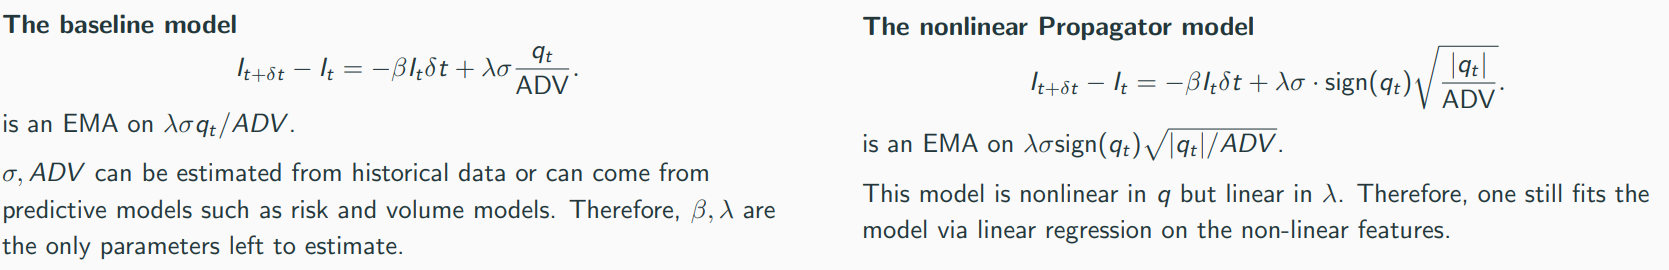

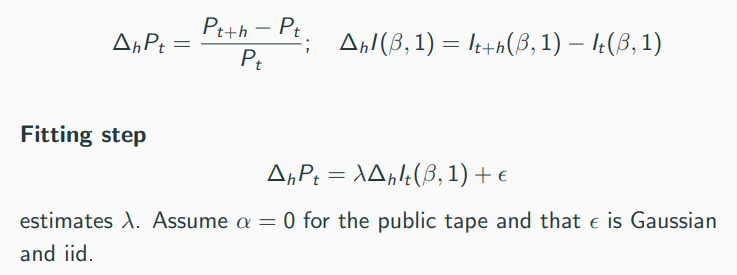

In [19]:
half_lifes = [60,600,1200]
explanation_periods = [25,500,1000] 
in_sample_month = 1

index_regression_compute = 1
for half_life in half_lifes:
    # price_impact_model.compute_and_store_impact(half_life=half_life,model_type="linear") #optionnal
    # price_impact_model.compute_and_store_impact(half_life=half_life,model_type="sqrt") #optionnal
    for explanation_period in explanation_periods:
        price_impact_model.regression_by_model(half_life=half_life,model_type="linear",explanation_period=explanation_period,in_sample_month=in_sample_month)
        price_impact_model.regression_by_model(half_life=half_life,model_type="sqrt",explanation_period=explanation_period,in_sample_month=in_sample_month)
        print(f"Computing {index_regression_compute} out of {len(half_lifes)*len(explanation_periods)} regressions ...",end="\r")
        index_regression_compute+=1

In [20]:
price_impact_model.get_regression_result_by_key(("linear",60,25,1)).head(2)

,is_xy,is_xx,is_yy,is_x,is_y,is_count,oos_xy,oos_xx,oos_yy,oos_x,oos_y,oos_count,beta_estimate,alpha_estimate,is_sse,is_mse,is_rsq,oos_sse,oos_mse,oos_rsq
stock,,,,,,,,,,,,,,,,,,,,
A,2.963895e-11,2.334143e-09,0.006899,-0.000034,-0.242609,2316,1.167253e-06,2.734919e-08,0.075146,0.000042,2.459970,44004,0.012698,-0.000105,0.006874,0.006874,-1.319142e-08,0.075008,0.076144,-0.015142
AAL,1.659872e-06,3.705580e-07,0.056063,0.000511,1.500806,48636,-2.396864e-07,6.457793e-08,0.336612,0.000215,2.659975,44004,4.479449,0.000031,0.056016,0.056009,1.302124e-04,0.336451,0.336493,-0.000125


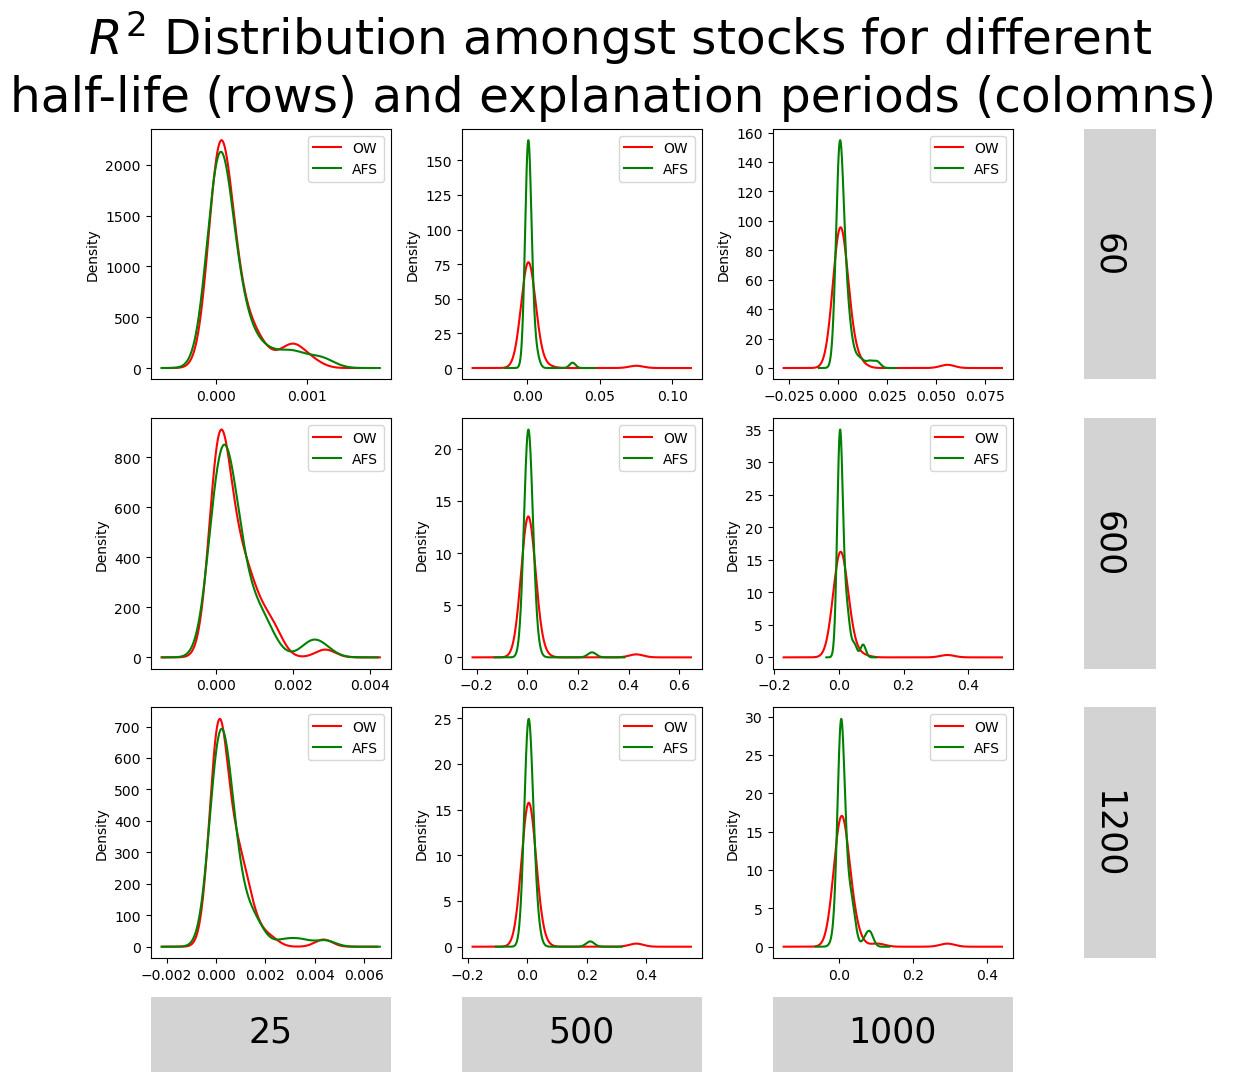

In [21]:
height_ratios = [1.] * len(half_lifes) +  [0.3]
width_ratios = [1.] * len(explanation_periods) + [0.3]

fig,axs = plt.subplots(len(half_lifes)+1,len(explanation_periods)+1,figsize=(len(explanation_periods)*3 + 2,len(half_lifes)*3 + 2),gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})
color_model = {"linear":"red","sqrt":"green"}
for hf_index,half_life in enumerate(half_lifes):
    for ep_index,explanation_period in enumerate(explanation_periods):
        ax = axs[hf_index][ep_index]
        price_impact_model.get_regression_result_by_key(("linear",half_life,explanation_period,in_sample_month))["is_rsq"].plot.kde(ax=ax,color =color_model.get("linear"),label="OW")
        price_impact_model.get_regression_result_by_key(("sqrt",half_life,explanation_period,in_sample_month))["is_rsq"].plot.kde(ax=ax,color =color_model.get("sqrt"),label = "AFS")
        # ax.set_title(f"{half_life} / {explanation_period}")
        ax.legend()

for hf_index,half_life in enumerate(half_lifes):
    ax = axs[hf_index][-1]
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(0, 1)
    ax.text( 0.1, 0.5, half_life,fontsize = 25, va='center', transform=ax.transAxes,rotation=270)
    ax.set_facecolor("#D3D3D3")
    for spine in ax.spines.values():
        spine.set_visible(False)
for ep_index,explanation_period in enumerate(explanation_periods):
    ax = axs[-1][ep_index]
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0.5, 0.4, explanation_period, fontsize = 25,ha='center')
    ax.set_facecolor("#D3D3D3")
    for spine in ax.spines.values():
        spine.set_visible(False)
ax = axs[-1][-1]
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
fig.suptitle(t="$R^2$ Distribution amongst stocks for different \nhalf-life (rows) and explanation periods (colomns) ",fontsize = 35)
plt.tight_layout()
plt.show()

# Remove the price impact

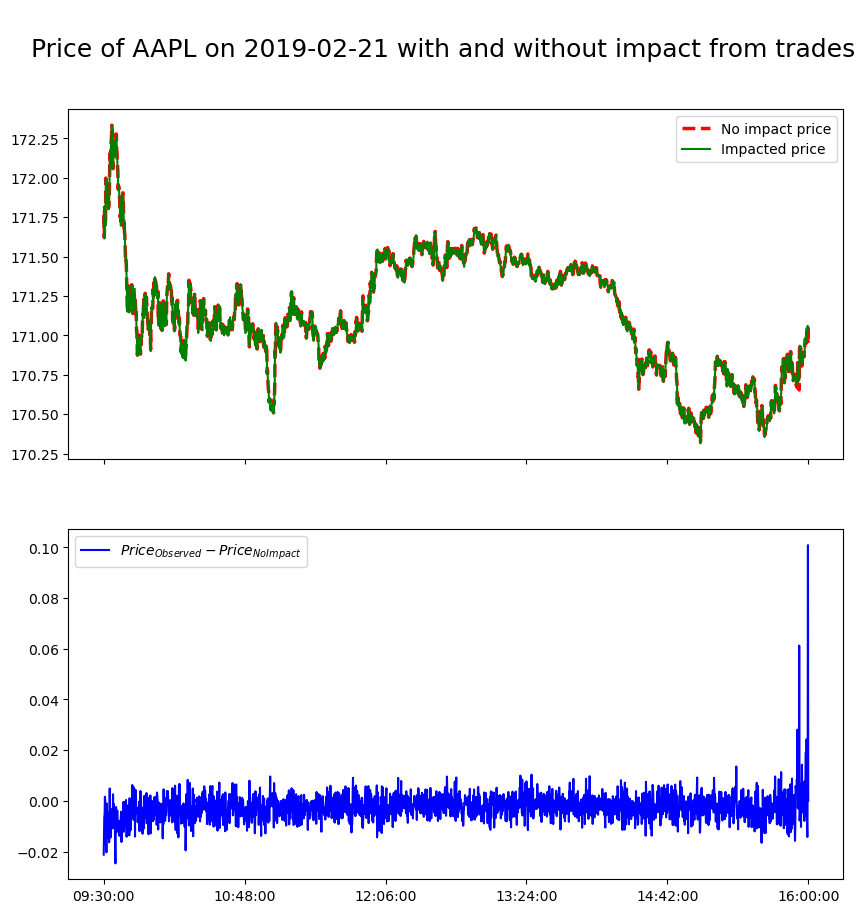

In [24]:
date = "2019-02-21"
stock = "AAPL"
price_no_impact = price_impact_model.get_no_impact_adjusted_prices_df(half_life=DEFAULT_HALF_LIFE,model_type = "sqrt")

price_no_impact_values = price_no_impact.loc[stock].loc[date]
price_osberved_values = price_impact_model.get_bin_traded_px().loc[stock].loc[date]

fig,axs = plt.subplots(2,1,figsize = (10,10),sharex=True)
x_values = price_no_impact.columns
ax = axs[0]
ax.plot(x_values,price_no_impact_values,color = "red",label="No impact price",linestyle = "dashed",linewidth = 2.5)
ax.plot(x_values,price_osberved_values,color = "green",label="Impacted price")
ax.legend()
ax = axs[1]
ax.plot(x_values,price_osberved_values - price_no_impact_values,color = "blue",label="$Price_{Observed} - Price_{No Impact}$")
step = len(ax.get_xticks()) // 5
ax.set_xticks(ax.get_xticks()[::step])
ax.legend()
fig.suptitle(f"\nPrice of {stock} on {date} with and without impact from trades",fontsize = 18)
plt.show()